# Deep Learning
***Name***: *Aviv Nutovitz 201325750*

### Import Packages

In [0]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Embedding, LSTM, GRU, TimeDistributed
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import os, time
from google.colab import files
import collections
import tensorflow as tf
import numpy as np
import math



Using TensorFlow backend.


In [0]:
# first upload the data files from your local file system:
uploadedFiles = files.upload()

Saving ptb.test.txt to ptb.test.txt
Saving ptb.train.txt to ptb.train.txt
Saving ptb.valid.txt to ptb.valid.txt


### Model Architecture

In [0]:
#class Model:
class Model:
  """
  modelTypeDict - dictionary with the type of regularization and the reuquired parameters: 
  1. {"L":"none"} (LSTM based network without dropout)
  2. {"LD":"0.5"} (LSTM based network with dropout)
  3. {"G":"none"} (GRU based network without dropout)
  4. {"GD":"0.5"} (GRU based network with dropout)
  """
  @staticmethod
  def build(model_type_dict, vocabulary, hidden_size=200, num_steps=20):
    # initialize the model
    model = Sequential()
    # parameters for the diffrent types of regularization
    type_key = next(iter(model_type_dict))
    type_value = model_type_dict[type_key]
    
    # embedding layer
    model.add(Embedding(vocabulary, hidden_size, input_length=num_steps))
    
    # for LSTM model
    if 'L' in type_key:
      # first layer
      model.add(LSTM(hidden_size, return_sequences=True))
      # add dropouts
      if 'D' in type_key:
        model.add(Dropout(float(type_value)))
      # scound layer
      model.add(LSTM(hidden_size, return_sequences=True))
      # add dropouts
      if 'D' in type_key:
        model.add(Dropout(float(type_value)))
    # for GRU model
    else:
      # first layer
      model.add(GRU(hidden_size, return_sequences=True))
      # add dropouts
      if 'D' in type_key:
        model.add(Dropout(float(type_value)))
      # scound layer
      model.add(GRU(hidden_size, return_sequences=True))
      # add dropouts
      if 'D' in type_key:
        model.add(Dropout(float(type_value)))
    
    model.add(TimeDistributed(Dense(vocabulary)))
    model.add(Activation('softmax'))
    
    return model
    
def build_model(model_type, vocabulary):
  model = Model.build(model_type, vocabulary)
  model.compile(loss='categorical_crossentropy', optimizer=Adam(clipnorm=5.), metrics=['categorical_accuracy'])
  return model


### Data Preprocessing

In [0]:
class BatchGenerator:

    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step=5):
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set
        self.skip_step = skip_step

    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps))
        y = np.zeros((self.batch_size, self.num_steps, self.vocabulary))
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps >= len(self.data):
                    # reset the index back to the start of the data set
                    self.current_idx = 0
                x[i, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
                temp_y = self.data[self.current_idx + 1:self.current_idx + self.num_steps + 1]
                # convert all of temp_y into a one hot representation
                y[i, :, :] = to_categorical(temp_y, num_classes=self.vocabulary)
                self.current_idx += self.skip_step
            yield x, y

In [0]:
# helper functions
def read_words(filename):
    with tf.gfile.GFile(filename, "r") as f:
        return f.read().replace("\n", "<eos>").split()

def build_vocab(filename):
    data = read_words(filename)

    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))

    return word_to_id

def file_to_word_ids(filename, word_to_id):
    data = read_words(filename)
    return [word_to_id[word] for word in data if word in word_to_id]
  
def load_data():
  # build the complete vocabulary, then convert text data to list of integers
  train_path = 'ptb.train.txt'
  valid_path = 'ptb.valid.txt'
  test_path = 'ptb.test.txt'

  word_to_id = build_vocab(train_path)
  train_data = file_to_word_ids(train_path, word_to_id)
  valid_data = file_to_word_ids(valid_path, word_to_id)
  test_data = file_to_word_ids(test_path, word_to_id)
  vocabulary = len(word_to_id)
  reversed_dictionary = dict(zip(word_to_id.values(), word_to_id.keys()))

  return train_data, valid_data, test_data, vocabulary, reversed_dictionary

### Train Model and Plot Graphs:
- Train model
- Evaluate using test set
- Saving the model to be loaded for testing purposes

In [0]:
#https://github.com/keras-team/keras/issues/2548

from tensorflow.keras.callbacks import Callback

tr_loss_list,tr_acc_list,tr_epochs_list=[],[],[]
v_loss_list,v_acc_list,v_epochs_list=[],[],[]
te_loss_list,te_acc_list,te_epochs_list=[],[],[]

class TestCallback(Callback):
    def __init__(self, tr_data,tr_name,v_data,v_name,te_data,te_name):
        self.tr_data = tr_data
        self.tr_name = tr_name
        self.v_data = v_data
        self.v_name = v_name
        self.te_data = te_data
        self.te_name = te_name


    def on_epoch_end(self, epoch, logs={}):
      print("\nEvaluating loss on " + self.tr_name + " at the end of epoch " + str(epoch+1) + "...")
      t1 = time.time()
      steps_per_epoch = len(self.tr_data)//(batch_size*num_steps)
      data_generator = BatchGenerator(self.tr_data, num_steps, batch_size, vocabulary)
      loss, acc = self.model.evaluate_generator(data_generator.generate(), steps=steps_per_epoch)
      tr_loss_list.append(loss)
      tr_acc_list.append(acc)
      tr_epochs_list.append(epoch)          
      print('Loss: {}, acc: {}'.format(loss, acc))
      t2 = time.time()
      print("Total evaluation time: %0.2fs\n" % (t2 - t1))
       
      steps_per_epoch = len(self.v_data)//(batch_size*num_steps)
      data_generator = BatchGenerator(self.v_data, num_steps, batch_size, vocabulary)
      loss, acc = self.model.evaluate_generator(data_generator.generate(), steps=steps_per_epoch)
      v_loss_list.append(loss)
      v_acc_list.append(acc)
      v_epochs_list.append(epoch)          

      print("\nEvaluating loss on " + self.te_name + " at the end of epoch " + str(epoch+1) + "...")
      t1 = time.time()
      steps_per_epoch = len(self.te_data)//(batch_size*num_steps)
      data_generator = BatchGenerator(self.te_data, num_steps, batch_size, vocabulary)
      loss, acc = self.model.evaluate_generator(data_generator.generate(), steps=steps_per_epoch)
      te_loss_list.append(loss)
      te_acc_list.append(acc)
      te_epochs_list.append(epoch)          
      print('Loss: {}, acc: {}'.format(loss, acc))
      t2 = time.time()
      print("Total evaluation time: %0.2fs\n" % (t2 - t1))


In [0]:
# train model
def train_type(net_type, train_data, valid_data, test_data, num_steps, batch_size, vocabulary,num_epochs):
  # build & compile the model for the training
  model = build_model(net_type, vocabulary)
  
  checkpoint_path = "training_{}/cp.ckpt".format(next(iter(net_type)))
  checkpoint_dir = os.path.dirname(checkpoint_path)
  # create dir if not exsit
  !mkdir {checkpoint_dir}
  
  # Create checkpoint callback
  # EarlyStopping will stop training when loss hasn't improved for 10 epochs
  cp_callback = ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)
  my_callbacks = [cp_callback, EarlyStopping(monitor='loss', patience=10, verbose=1, min_delta=1e-4),TestCallback(train_data,"train",valid_data,"validation",test_data,"test")]
  
  # train, valid & test parameters
  steps_per_train_epoch = len(train_data)//(batch_size*num_steps)
  steps_per_valid_epoch = len(valid_data)//(batch_size*num_steps)
  steps_per_test_epoch = len(test_data)//(batch_size*num_steps)
  
  # setup train, valid & test data
  train_data_generator = BatchGenerator(train_data, num_steps, batch_size, vocabulary)
  valid_data_generator = BatchGenerator(valid_data, num_steps, batch_size, vocabulary)
  test_data_generator = BatchGenerator(test_data, num_steps, batch_size, vocabulary)
  
  # Measure training time
  t1 = time.time() 
  np.random.seed(2018)
  tf.set_random_seed(2018)

  history = model.fit_generator(train_data_generator.generate(), steps_per_epoch=steps_per_train_epoch, epochs=num_epochs, 
                                validation_data=valid_data_generator.generate(), 
                                validation_steps=steps_per_valid_epoch, callbacks=my_callbacks)#,shuffle=False)

  t2 = time.time()
  print("Total training time: %0.2fs" % (t2 - t1))
  
  # return the saved model path and history
  return checkpoint_path, history
  

In [0]:
# plot graphs
def plot_graphs(history, net_type):
  
  categorical_accuracy_list = history.history['categorical_accuracy']
  val_categorical_accuracy_list = history.history['val_categorical_accuracy']
  loss_list = history.history['loss']
  val_loss_list = history.history['val_loss']
  perplexity_lst = [math.exp(x) for x in loss_list]
  val_perplexity_lst = [math.exp(x) for x in val_loss_list]
  
  # summarize history for accuracy
  plt.plot(categorical_accuracy_list)
  plt.plot(val_categorical_accuracy_list)
  plt.title('model categorical accuracy for {}'.format(next(iter(net_type))))
  plt.ylabel('categorical accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
   
  # summarize history for perplexity
  plt.plot(perplexity_lst)
  plt.plot(val_perplexity_lst)
  plt.title('model perplexity for {}'.format(next(iter(net_type))))
  plt.ylabel('perplexity')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [0]:
# plot graphs
def plot_graphs_second_type(history, net_type, tr_loss_list, tr_acc_list, tr_epochs_list):
  
  categorical_accuracy_list = history.history['categorical_accuracy']
  val_categorical_accuracy_list = history.history['val_categorical_accuracy']
  loss_list = history.history['loss']
  val_loss_list = history.history['val_loss']
  perplexity_lst = [math.exp(x) for x in loss_list]
  val_perplexity_lst = [math.exp(x) for x in val_loss_list]
  tr_perplexity_lst = [math.exp(x) for x in tr_loss_list]
  
  # summarize history for accuracy
  plt.plot(tr_epochs_list,tr_acc_list)
  plt.plot(np.arange(0, len(val_perplexity_lst), 1),val_categorical_accuracy_list)
  plt.title('model categorical accuracy for {}'.format(next(iter(net_type))))
  plt.ylabel('categorical accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  # summarize history for perplexity
  plt.plot(tr_epochs_list,tr_perplexity_lst)
  plt.plot(np.arange(0, len(val_perplexity_lst), 1),val_perplexity_lst)
  plt.title('model perplexity for {}'.format(next(iter(net_type))))
  plt.ylabel('perplexity')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

### Load model and check test final results

In [0]:
def test_validation_type(net_type, data, vocabulary, num_steps, batch_size, checkpoint_path, dataset_type="test"):
  # build & compile the model for the training
  model = build_model(net_type, vocabulary)
  
  # test parameters step size
  steps_per_epoch = len(data)//(batch_size*num_steps)
  
  # setup data
  data_generator = BatchGenerator(data, num_steps, batch_size, vocabulary)
  
  model.load_weights(checkpoint_path)
  loss, acc = model.evaluate_generator(data_generator.generate(), steps=steps_per_epoch)
  print("Restored model, perplexity: {:5.2f}".format(math.exp(loss)))
  print("------------------------Done " + dataset_type + " stage: {}------------------------".format(net_type))
  

### Run Different Types

In [0]:
# get the data for the training
train_data, valid_data, test_data, vocabulary, reversed_dictionary = load_data()

# pick one to the following types
type_1 = {"L":"none"}

type_2 = {"LD":"0.5"}

type_3 = {"G":"none"}

type_4 = {"GD":"0.5"}

num_steps = 20
batch_size = 20

#### LSTM without Dropouts 

In [0]:
n_epochs = 60
tr_loss_list, tr_acc_list, tr_epochs_list = [], [], []
te_loss_list, te_acc_list, te_epochs_list = [], [], []
v_loss_list, v_acc_list, v_epochs_list = [], [], []

checkpoint_path_type_1, history_1 = train_type(net_type=type_1, train_data=train_data, valid_data=valid_data, test_data=test_data, num_steps=num_steps, batch_size=batch_size, vocabulary=vocabulary,num_epochs=n_epochs)
print("Model saved into: {}".format(checkpoint_path_type_1))

tr_loss_list_1, tr_acc_list_1, tr_epochs_list_1 = tr_loss_list, tr_acc_list, tr_epochs_list
te_loss_list_1, te_acc_list_1, te_epochs_list_1 = te_loss_list, te_acc_list, te_epochs_list
v_loss_list_1, v_acc_list_1, v_epochs_list_1 = v_loss_list, v_acc_list, v_epochs_list

Epoch 1/60
2323/2323 [==============================] - 325s 140ms/step - loss: 7.0475 - categorical_accuracy: 0.0554 - val_loss: 6.7980 - val_categorical_accuracy: 0.0748

Epoch 00001: saving model to training_L/cp.ckpt

Evaluating loss on train at the end of epoch 1...
Loss: 6.672907470887045, acc: 0.0706381833794584
Total evaluation time: 146.21s


Evaluating loss on test at the end of epoch 1...
Loss: 6.663141109410999, acc: 0.07114077674098385
Total evaluation time: 13.14s

Epoch 2/60
2323/2323 [==============================] - 322s 138ms/step - loss: 6.5322 - categorical_accuracy: 0.0907 - val_loss: 6.3017 - val_categorical_accuracy: 0.1133

Epoch 00002: saving model to training_L/cp.ckpt
Epoch 3/60
2323/2323 [==============================] - 321s 138ms/step - loss: 6.2540 - categorical_accuracy: 0.1200 - val_loss: 5.9418 - val_categorical_accuracy: 0.1516

Epoch 00003: saving model to training_L/cp.ckpt
Epoch 4/60
2323/2323 [==============================] - 322s 139ms/step - 

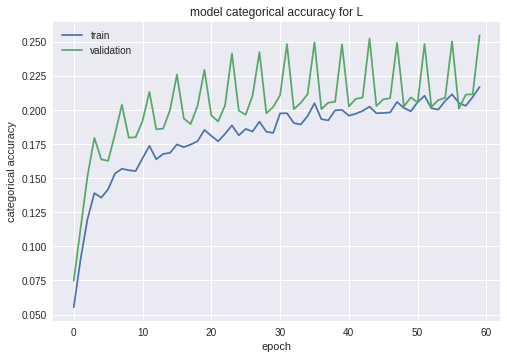

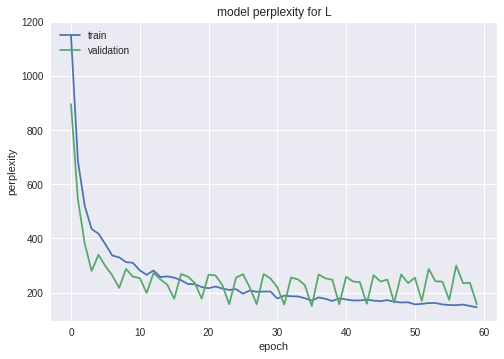

In [0]:
# plot results
plot_graphs(history_1, type_1)

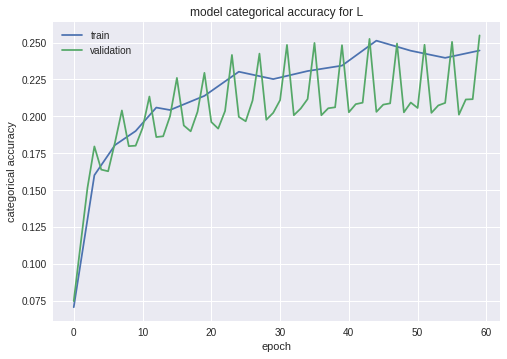

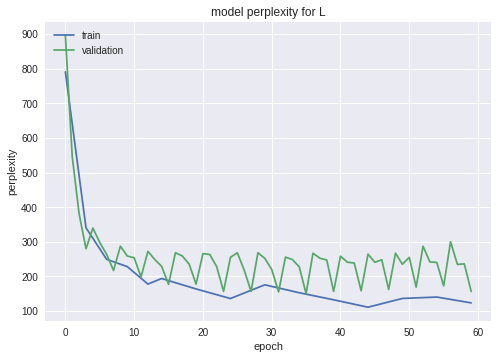

In [0]:
plot_graphs2(history_1, type_1, tr_loss_list_1, tr_acc_list_1, tr_epochs_list_1)

#### LSTM with Dropouts 

In [0]:
n_epochs = 60
tr_loss_list, tr_acc_list, tr_epochs_list = [], [], []
te_loss_list, te_eacc_list, te_epochs_list = [], [], []
v_loss_list, v_acc_list, v_epochs_list = [], [], []

checkpoint_path_type_2, history_2 = train_type(net_type=type_2, train_data=train_data, valid_data=valid_data, test_data=test_data, num_steps=num_steps, batch_size=batch_size, vocabulary=vocabulary,num_epochs=n_epochs)
print("Model saved into: {}".format(checkpoint_path_type_2))

tr_loss_list_2, tr_acc_list_2, tr_epochs_list_2 = tr_loss_list, tr_acc_list, tr_epochs_list
te_loss_list_2, te_acc_list_2, te_epochs_list_2 = te_loss_list,te_acc_list, te_epochs_list
v_loss_list_2, v_acc_list_2, v_epochs_list_2 = v_loss_list, v_acc_list, v_epochs_list

Epoch 1/60
2323/2323 [==============================] - 354s 152ms/step - loss: 7.0317 - categorical_accuracy: 0.0546 - val_loss: 6.6455 - val_categorical_accuracy: 0.0615

Epoch 00001: saving model to training_LD/cp.ckpt

Evaluating loss on train at the end of epoch 1...
Loss: 6.553741400887419, acc: 0.05653572969601277
Total evaluation time: 156.54s


Evaluating loss on validation at the end of epoch 1...
Loss: 6.640387345915255, acc: 0.061372282542794455
Total evaluation time: 12.46s


Evaluating loss on test at the end of epoch 1...
Loss: 6.546893392951743, acc: 0.060703883390620494
Total evaluation time: 14.05s

Epoch 2/60
2323/2323 [==============================] - 351s 151ms/step - loss: 6.6446 - categorical_accuracy: 0.0793 - val_loss: 6.4465 - val_categorical_accuracy: 0.0999

Epoch 00002: saving model to training_LD/cp.ckpt
Epoch 3/60
2323/2323 [==============================] - 350s 151ms/step - loss: 6.4662 - categorical_accuracy: 0.0989 - val_loss: 6.2544 - val_categorica

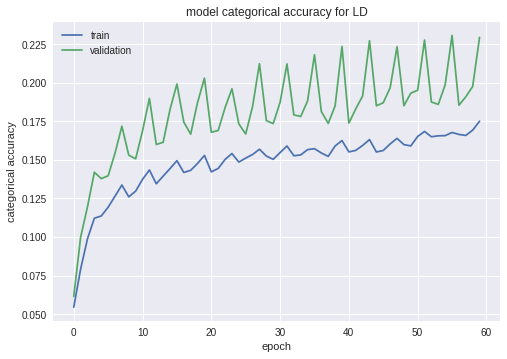

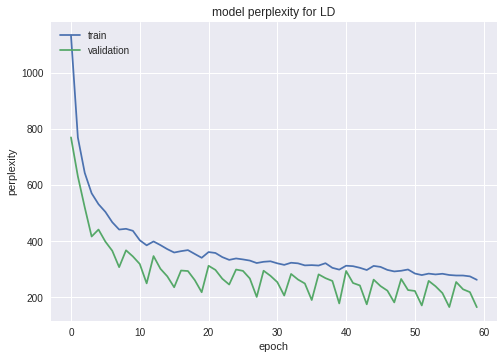

In [0]:
# plot results
plot_graphs(history_2, type_2)

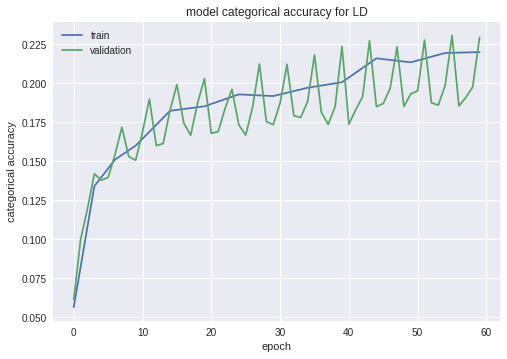

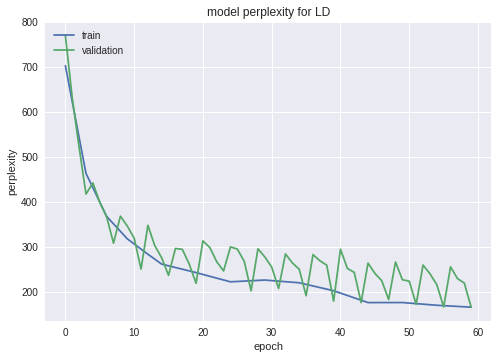

In [0]:
plot_graphs2(history_2, type_2, tr_loss_list_2, tr_acc_list_2, tr_epochs_list_2)

#### GRU without Dropouts 

In [0]:
n_epochs = 20
tr_loss_list, tr_acc_list, tr_epochs_list = [], [], []
te_loss_list, te_acc_list, te_epochs_list = [], [], []
v_loss_list, v_acc_list, v_epochs_list = [], [], []

checkpoint_path_type_3, history_3 = train_type(net_type=type_3, train_data=train_data, valid_data=valid_data, test_data=test_data, num_steps=num_steps, batch_size=batch_size, vocabulary=vocabulary,num_epochs=n_epochs)
print("Model saved into: {}".format(checkpoint_path_type_3))

tr_loss_list_3, tr_acc_list_3, tr_epochs_list_3 = tr_loss_list, tr_acc_list, tr_epochs_list
te_loss_list_3, te_acc_list_3, te_epochs_list_3 = te_loss_list, te_acc_list, te_epochs_list
v_loss_list_3, v_acc_list_3, v_epochs_list_3 = v_loss_list, v_acc_list, v_epochs_list

Epoch 1/20
2323/2323 [==============================] - 279s 120ms/step - loss: 6.7452 - categorical_accuracy: 0.0695 - val_loss: 6.2499 - val_categorical_accuracy: 0.1246

Epoch 00001: saving model to training_G/cp.ckpt

Evaluating loss on train at the end of epoch 1...
Loss: 6.16511021345995, acc: 0.12519479093786923
Total evaluation time: 128.77s


Evaluating loss on test at the end of epoch 1...
Loss: 6.152568275488696, acc: 0.12133495122628304
Total evaluation time: 11.64s

Epoch 2/20
2323/2323 [==============================] - 279s 120ms/step - loss: 6.1499 - categorical_accuracy: 0.1292 - val_loss: 5.8197 - val_categorical_accuracy: 0.1585

Epoch 00002: saving model to training_G/cp.ckpt
Epoch 3/20
2323/2323 [==============================] - 275s 118ms/step - loss: 5.8817 - categorical_accuracy: 0.1535 - val_loss: 5.5282 - val_categorical_accuracy: 0.1852

Epoch 00003: saving model to training_G/cp.ckpt
Epoch 4/20
2323/2323 [==============================] - 274s 118ms/step - 

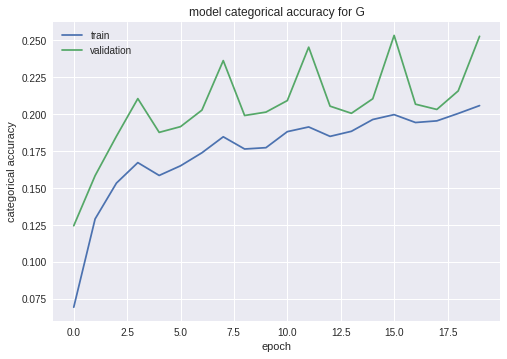

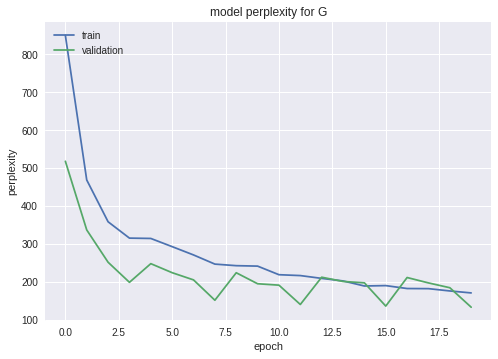

In [0]:
# plot results
plot_graphs(history_3, type_3)

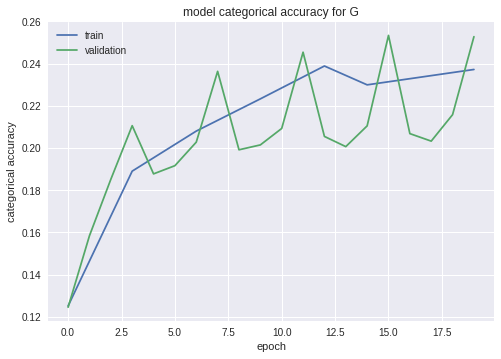

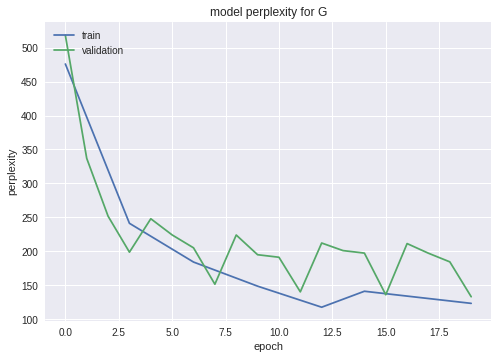

In [0]:
plot_graphs2(history_3, type_3, tr_loss_list_3, tr_acc_list_3, tr_epochs_list_3)

#### GRU with Dropouts 

In [0]:
n_epochs=20
tr_loss_list, tr_acc_list, tr_epochs_list= [], [], []
te_loss_list, te_acc_list, te_epochs_list=[], [], []
v_loss_list, v_acc_list, v_epochs_list=[], [], []

checkpoint_path_type_4, history_4 = train_type(net_type=type_4, train_data=train_data, valid_data=valid_data, test_data=test_data, num_steps=num_steps, batch_size=batch_size, vocabulary=vocabulary,num_epochs=n_epochs)
print("Model saved into: {}".format(checkpoint_path_type_4))

tr_loss_list_4, tr_acc_list_4, tr_epochs_list_4=tr_loss_list, tr_acc_list, tr_epochs_list
te_loss_list_4, te_acc_list_4, te_epochs_list_4=te_loss_list, te_acc_list, te_epochs_list
v_loss_list_4, v_acc_list_4, v_epochs_list_4=v_loss_list, v_acc_list, v_epochs_list

Epoch 1/20
2323/2323 [==============================] - 290s 125ms/step - loss: 6.7899 - categorical_accuracy: 0.0668 - val_loss: 6.3324 - val_categorical_accuracy: 0.1137

Epoch 00001: saving model to training_GD/cp.ckpt

Evaluating loss on train at the end of epoch 1...
Loss: 6.240485579096137, acc: 0.11342337471643464
Total evaluation time: 133.11s


Evaluating loss on test at the end of epoch 1...
Loss: 6.227222713451941, acc: 0.11061893177480953
Total evaluation time: 11.83s

Epoch 2/20
2323/2323 [==============================] - 289s 124ms/step - loss: 6.2837 - categorical_accuracy: 0.1196 - val_loss: 5.9052 - val_categorical_accuracy: 0.1514

Epoch 00002: saving model to training_GD/cp.ckpt
Epoch 3/20
2323/2323 [==============================] - 288s 124ms/step - loss: 6.0421 - categorical_accuracy: 0.1419 - val_loss: 5.6301 - val_categorical_accuracy: 0.1773

Epoch 00003: saving model to training_GD/cp.ckpt
Epoch 4/20
2323/2323 [==============================] - 288s 124ms/ste

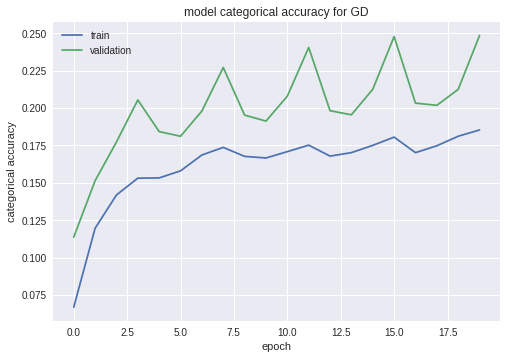

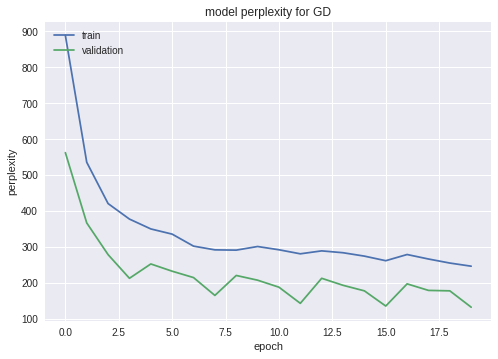

In [0]:
# plot results
plot_graphs(history_4, type_4)

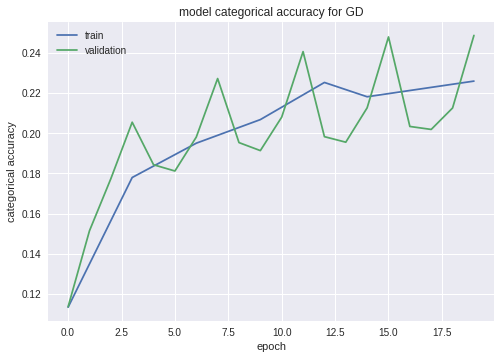

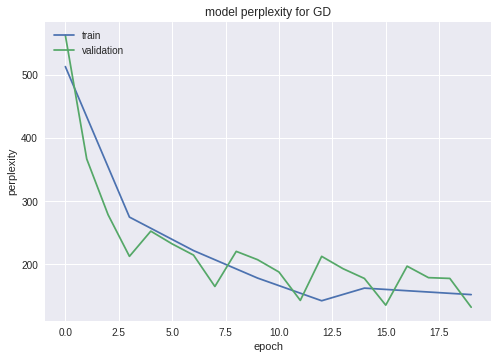

In [0]:
plot_graphs2(history_4, type_4, tr_loss_list_4, tr_acc_list_4, tr_epochs_list_4)